# Customer Compliance - CFPB

## EAD2

### 1. Import packages

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Basic operations
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('white')

# 
import scipy as sp
from sklearn.metrics import *

### 2. Load data
<br>
Load the dataset that is cleaned before. To make deeper analysis on relevance.

In [2]:
data = pd.read_csv('./cleaned_1.csv')
data.shape

(860606, 12)

In [3]:
data.head(3)

,Date_received,Product,Issue,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Is_Timely_response,Is_Consumer_disputed,Complaint_ID
0,03/12/2014,Mortgage,"Loan modification,collection,foreclosure",M&T BANK CORPORATION,MI,48382,Referral,03/17/2014,Closed with explanation,1,No,759217
1,10/01/2016,Credit reporting,Incorrect information on credit report,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,Web,10/05/2016,Closed with explanation,1,No,2141773
2,10/17/2016,Consumer Loan,Managing the loan or lease,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Web,10/20/2016,Closed with explanation,1,No,2163100


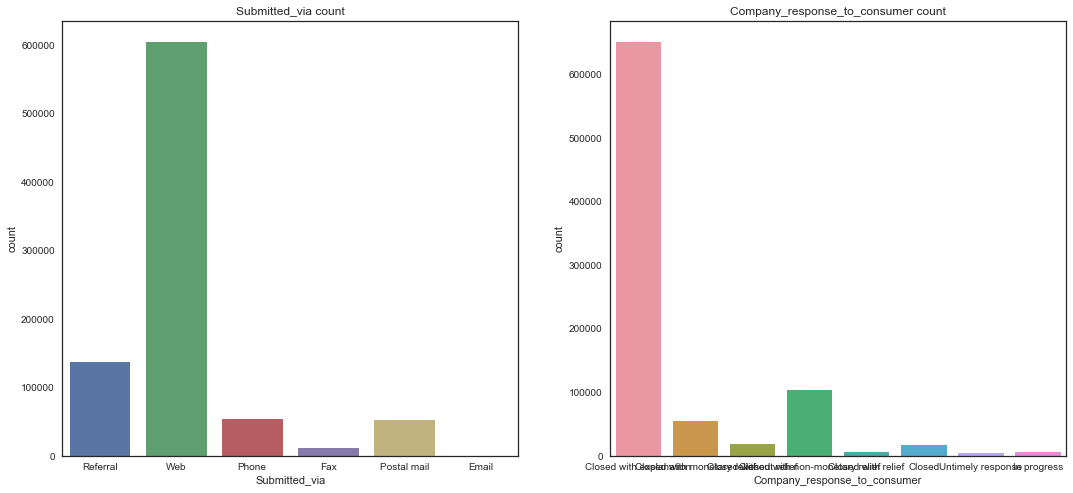

In [23]:
f, ax = plt.subplots(1,2,figsize=(18,8))

sns.countplot('Submitted_via', data=data, ax=ax[0])
sns.countplot('Company_response_to_consumer', data=data, ax=ax[1])

ax[0].set_title('Submitted_via count')
ax[1].set_title('Company_response_to_consumer count')

plt.show()

---

### 3. Chi Square Test (i.v. & d.v.)

In Chi Square Test, for p value, the smaller the better. And in our case all p values for 'Is_Timely_response' = 'No' is small, which means all features have some relationships with 'Is_Timely_response'.

In [8]:
def chi_square_test(S1, S2):
    crs_tab = pd.crosstab(S1, S2, margins=True)
    dim = crs_tab.shape[0]-1
    
    obs = crs_tab.ix[0:dim,0:2]
    
    exp =  np.outer(crs_tab["All"][0:dim], crs_tab.ix["All"][0:2]) / 860606
    exp = pd.DataFrame(exp)
    exp.index = obs.index
    
    res = sp.stats.chisquare(obs,exp)
    p_value = res.pvalue
    chi = res.statistic
    
    r = pd.DataFrame({'p_value': p_value, 'cs': chi})
   
    return r

In [9]:
p = []
index = []
data1 = data.drop(['Is_Timely_response','Complaint_ID'], axis=1)
label = data.Is_Timely_response

for col in data1:
    cs = chi_square_test(data1['%s'%col], label)
    index.append(col)
    p.append(cs.p_value[0])

cs_test = pd.DataFrame(index=index, data=p)
cs_test.columns=['p_value']
cs_test = cs_test.sort('p_value')
cs_test

,p_value
Date_received,0.000000e+00
Product,0.000000e+00
Issue,0.000000e+00
Company,0.000000e+00
Date_sent_to_company,0.000000e+00
Company_response_to_consumer,0.000000e+00
Is_Consumer_disputed,9.864516e-193
Submitted_via,5.549706e-118
State,1.293602e-61
ZIP_code,1.480492e-09


In [57]:
''' 
== Combined Chi Square test ==

chi_squared_stat = (((obs-exp)**2)/exp).sum().sum()
critical_value = sp.stats.chi2.ppf(q = 0.95, df = obs.shape[0]-1)  
p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat, df=obs.shape[0]-1)

==============================
'''

---

### 4. Mutual Infomation (d.v. & i.d.)

The relevances between features and 'Is_Timely_response' are listed below. For 'Is_Timely_response' = 'No, 'ZIP_code' has the lowest relevance.

In [10]:
def nmi(S1,S2):
    
    crs_tab = pd.crosstab(S1, S2, margins=True)
    dim = crs_tab.shape[0]-1
    
    obs = crs_tab.ix[0:dim,0:2]
    
    exp =  np.outer(crs_tab["All"][0:dim], crs_tab.ix["All"][0:2]) / 860606
    exp = pd.DataFrame(exp)
    exp.index = obs.index
    
    nmi1 = normalized_mutual_info_score(exp[1], obs[1])
    nmi0 = normalized_mutual_info_score(exp[0], obs[0])
    
    return nmi0, nmi1

In [11]:
index = []
mi = []

for col in data1:
    
    mi0, mi1 = nmi(data1['%s'%col], label)
    index.append(col)
    mi.append([mi0, mi1])
    
mi = pd.DataFrame(index=index, data=mi)
mi.columns = ['No', 'Yes']
mi = mi.sort(['No','Yes'], ascending=False)
mi

,No,Yes
Product,1.000000,1.000000
Submitted_via,1.000000,1.000000
Company_response_to_consumer,1.000000,1.000000
Is_Consumer_disputed,1.000000,1.000000
State,0.972534,1.000000
Issue,0.874571,0.989023
Date_sent_to_company,0.531280,0.858318
Date_received,0.506950,0.842570
Company,0.283091,0.630466
ZIP_code,0.209476,0.822798


### 5. Relevance between i.v.

** 'Product' & 'Submitted_via' **

In [12]:
a = pd.crosstab(data.Product, data.Submitted_via, normalize='index')

# b is the frequency of each 'Submitted_via' in data (average)
b = (pd.DataFrame(data.Submitted_via.value_counts())/data.shape[0]).T

for col in a:
    a['%s'%col] = a['%s'%col]/float(b['%s'%col])

# a is the 'frequency over average' of each 'Product'
a = a.sort('Web', ascending=False)

In [13]:
cm = sns.light_palette("green", as_cmap=True)
a = a.style.background_gradient(cmap=cm)
a

** 'Product' & 'Consumer_disputed' **

In [14]:
a = pd.crosstab(data.Product, data.Is_Consumer_disputed, normalize='index')
a.columns = ['NotKnow', 'No', 'Yes']

# b is the frequency of each 'Consumer_disputed' in data (average)
b = (pd.DataFrame(data.Is_Consumer_disputed.value_counts())/data.shape[0]).T
b.columns = ['No', 'Yes', 'NotKnow']

# a is the 'frequency over average' of each 'Product'
for col in a:
    a['%s'%col] = a['%s'%col]/float(b['%s'%col])

#a = a.sort('Web', ascending=False)

In [15]:
cm = sns.light_palette("green", as_cmap=True)
a = a.style.background_gradient(cmap=cm)
a

---

## Time Series

In [16]:
data.Date_received = pd.to_datetime(data.Date_received)
data.Date_sent_to_company = pd.to_datetime(data.Date_sent_to_company)

data['receive_year'] = data.Date_received.dt.year
data['receive_month'] = data.Date_received.dt.month

mean = data.Is_Timely_response.mean()

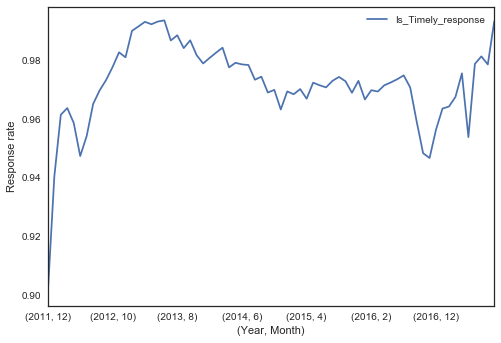

In [26]:
trend = data[['receive_year', 'receive_month', 'Is_Timely_response']]
trend.groupby(['receive_year', 'receive_month']).mean().plot()
plt.xlabel('(Year, Month)')
plt.ylabel('Response rate')
plt.show()

This plot shows the trend of response rate. We could notice that it goes up quickly from Dec 2011, and reach a peak at May or Jun 2013. and then goes down slowly till Nov 2016, then grows again till 2017.

---

These plots show the trend of response rate in year- /month- scale. The bule line is the mean response rate.

- There's a drop in 2011, that is because there is only one month (December) of records in 2011. 

- There're two drops in May and Sep - Dec. But still in a resonable range.

In [30]:
def yearly_response_rate(year):
    d = data[data.receive_year == year]
    rate = d.Is_Timely_response.mean()
    return rate

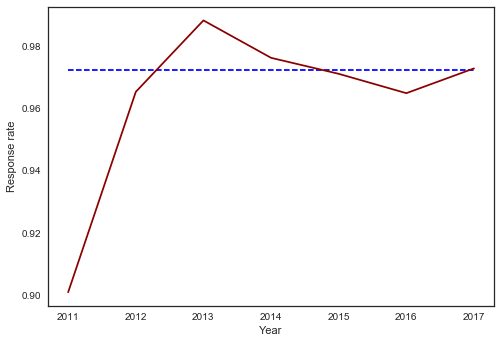

In [39]:
year = [2011,2012,2013,2014,2015,2016,2017]
yearly_res_rate = [yearly_response_rate(i) for i in year]

#plt.bar(year,yearly_res_rate,align='center', alpha=0.5)
tr_base = np.array([mean for i in range(len(year))])

plt.plot(year, tr_base, 'b--')


plt.plot(year,yearly_res_rate,'darkred')
plt.xlabel('Year')
plt.ylabel('Response rate')

plt.show()

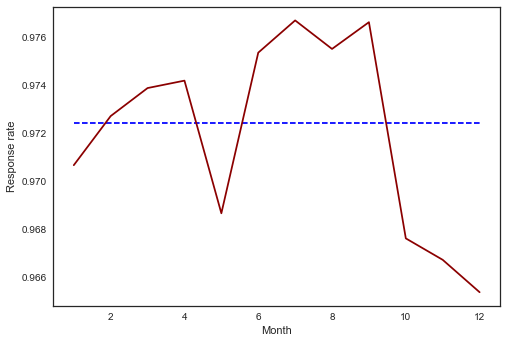

In [38]:
month=[]
for i in range(12):
    month.append(i+1) 

def monthly_response_rate(month):
    d = data[data.receive_month == month]
    rate = d.Is_Timely_response.mean()
    return rate

monthly_res_rate = [monthly_response_rate(i) for i in month]

#plt.bar(year,yearly_res_rate,align='center', alpha=0.5)
tr_base = np.array([mean for i in range(len(month))])

plt.plot(month, tr_base, 'b--')


plt.plot(month,monthly_res_rate,'darkred')
plt.xlabel('Month')
plt.ylabel('Response rate')

plt.show()

In [40]:
obj_col = list(data.columns[data.dtypes == 'object'])

In [41]:
data.dtypes

Date_received                   datetime64[ns]
Product                                 object
Issue                                   object
Company                                 object
State                                   object
ZIP_code                                object
Submitted_via                           object
Date_sent_to_company            datetime64[ns]
Company_response_to_consumer            object
Is_Timely_response                       int64
Is_Consumer_disputed                    object
Complaint_ID                             int64
receive_year                             int64
receive_month                            int64
dtype: object

In [ ]:
sns.barplot(x='Product',y='Is_Timely_response',data=data)
plt.show()